In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F


from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from glob import glob
from PIL import Image
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch import nn, optim

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 666
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else torch.device("cpu"))

In [3]:
Train_Path = 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*'

Test_Path = 'GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*'

In [4]:
# 训练集文件夹
train_folders = sorted(glob(Train_Path))

len(train_folders)

43

In [5]:
# 测试集文件
test_files = sorted(glob(Test_Path))

len(test_files)

12631

In [6]:
# 函数：根据路径，加载图片
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2BGRA) # 读取图片，并进行灰度转换
    if resize:
        img = cv2.resize(img, (64, 64)) # 改变图片尺寸大小
    return img

In [7]:
# 函数：显示图片
def show_img(img_path):
    img = load_image(img_path) # 调用函数
    plt.imshow(img) # 显示
    plt.axis('off') # 关闭坐标轴

In [8]:
# 函数：显示一批图片(一个网格所包含的图片)
def show_imgs_grid(img_paths):
    """
    img_paths : 很多图片的路径
    """
    images = [load_image(path) for path in img_paths] # 根据路径，读取一批图片
    print("images length : ", len(images))
    images = torch.as_tensor(images) # list类型转换为tensor类型
    print("images shape : ", images.shape)
    images = images.permute(0, 3, 1, 2) # 维度换位
    print("维度变换后的images shape : ", images.shape)
    grid_imgs = torchvision.utils.make_grid(images, nrow=8) # 将若干幅图像拼成一幅图像
    plt.figure(figsize=(24, 12)) # 画布大小
    print("grid_imgs shape : ", grid_imgs.shape)
    plt.imshow(grid_imgs.permute(1, 2, 0)) # 维度交换
    plt.axis('off') # 关闭坐标轴

In [9]:
# 依次从43个文件夹中， 从每个文件夹中随机获取一张图片的路径
sample_images = [np.random.choice(glob(f'{file_name}/*ppm')) for file_name in train_folders]

In [10]:
sample_images[0] # 第一张图片的路径

'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00000/00003_00019.ppm'

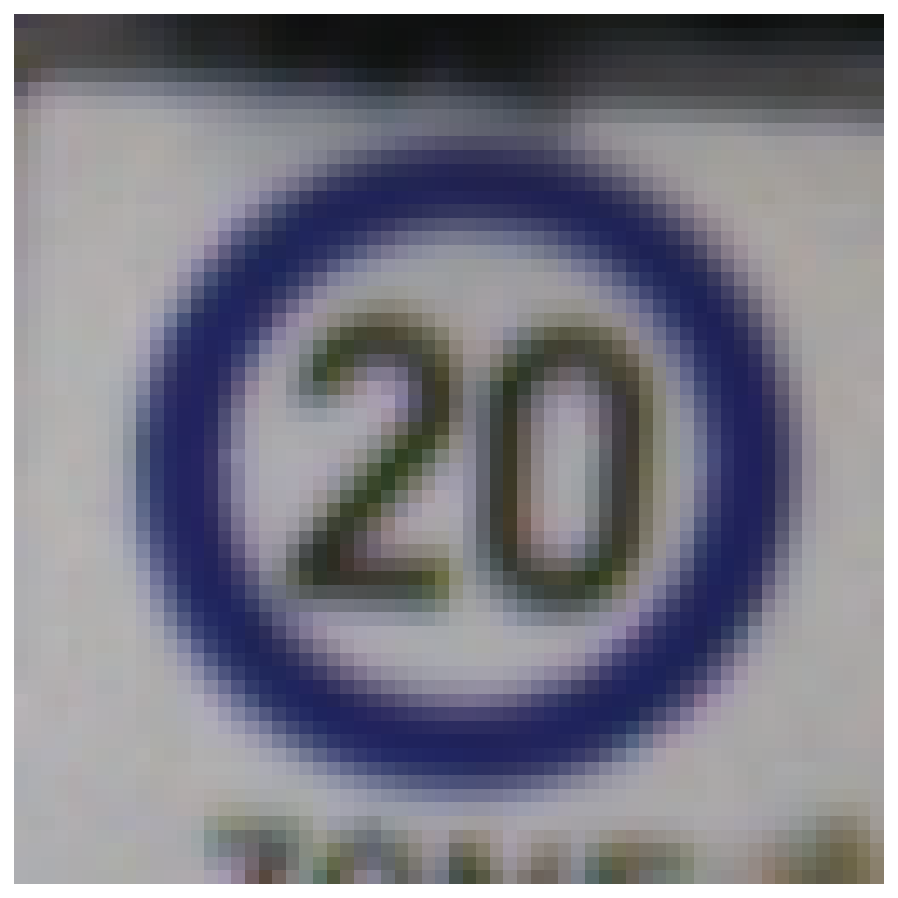

In [11]:
# 显示第一张图片
show_img(sample_images[0])

images length :  43
images shape :  torch.Size([43, 64, 64, 4])
维度变换后的images shape :  torch.Size([43, 4, 64, 64])
grid_imgs shape :  torch.Size([4, 398, 530])


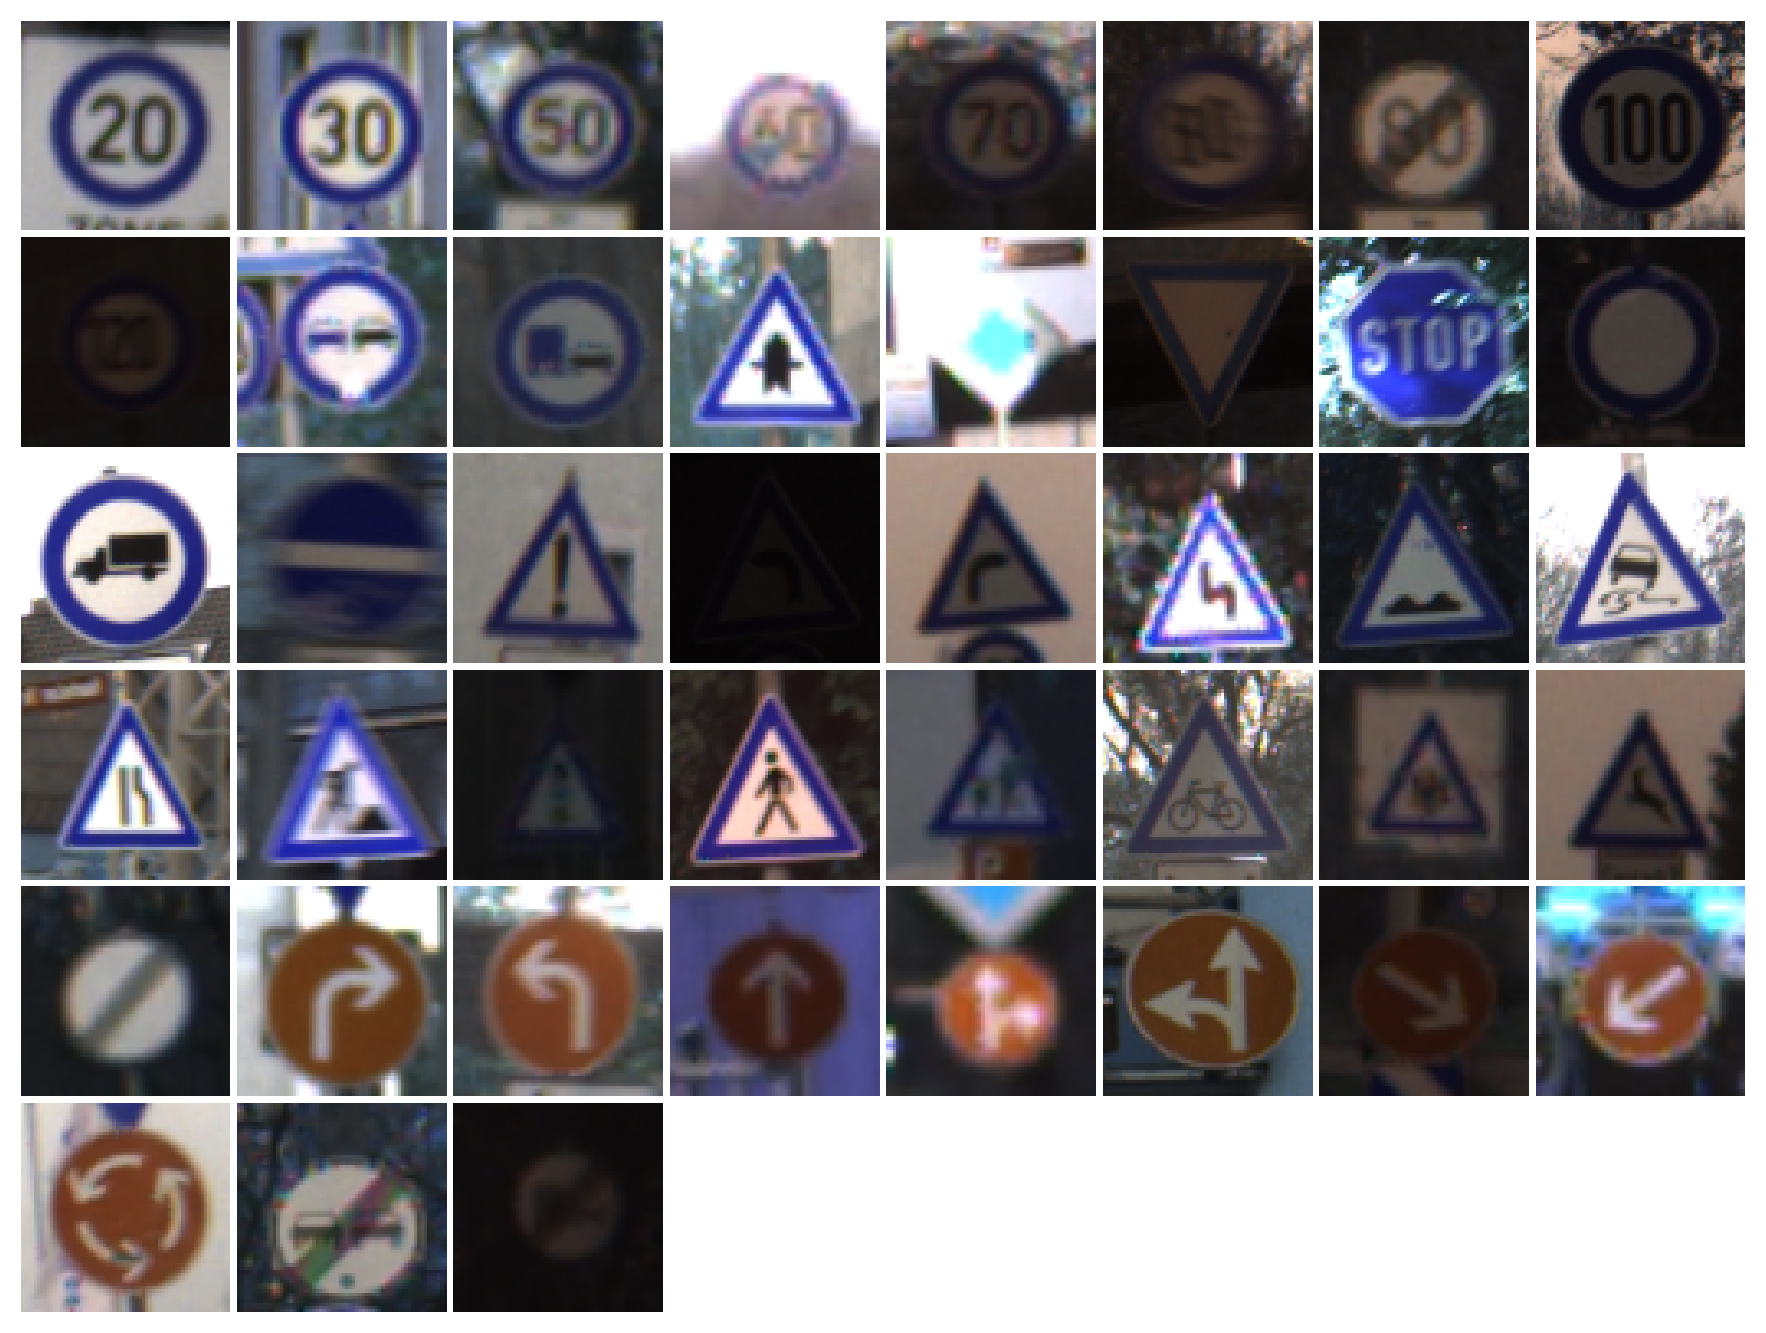

In [12]:
# 显示这批图片
show_imgs_grid(sample_images)

In [13]:
# # 类别名称
class_names = ['STOP', '禁止通行', '直行', '环岛行驶']

# 类别对应的文件夹序号： 00014， 00017， 00035， 00040
class_indices = [14, 17, 35, 40]

In [14]:
# 新建目录，将原始的train数据集分割成：train, val, test, 比例是70%, 20%, 10%

DATA_DIR = Path('New_Data_4_classes')

DATASETS = ['train', 'val', 'test']

for dt in DATASETS:
    for cls in class_names:
        (DATA_DIR/dt/cls).mkdir(parents=True, exist_ok=True) # exist_ok为True，则在目标目录已存在的情况下不会触发FileExistsError异常

In [15]:
# 从原始数据集拷贝图片到目标文件夹
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[int(cls_index)]}/*.ppm')) # 标签对应的所有图片路径
    class_name = class_names[i] # 标签
    print(f'{class_name} : {len(image_paths)}')
    np.random.shuffle(image_paths) # 打乱图片路径
    # 数据集切分，train : 70%, val : 20%, test : 10%
    # 本质上是索引切分
    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(0.7*len(image_paths)), int(0.9*len(image_paths))]
    )
    # 拼接
    dataset = zip(DATASETS, ds_split)
    
    for dt, img_pathes in dataset:
        print(f'{dt}, {len(img_pathes)}')
        for path in img_pathes:
            # 拷贝图片
            shutil.copy(path, f'{DATA_DIR}/{dt}/{class_name}/')

STOP : 780
train, 546
val, 156
test, 78
禁止通行 : 1110
train, 777
val, 222
test, 111
直行 : 1200
train, 840
val, 240
test, 120
环岛行驶 : 360
train, 251
val, 73
test, 36


In [16]:
# 数据增强
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transform = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size=256), # 随机裁剪
        transforms.RandomRotation(degrees=15), # 随机旋转
        transforms.RandomHorizontalFlip(), # 随机水平翻转
        transforms.ToTensor(), # 转换为tensor
    ]),
    
    'val':transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ]),
    
    'test':transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ])
}

In [17]:
# 定义数据加载器（ImageFolder假设所有的文件按文件夹保存，每个文件夹下存储同一个类别的图片，文件夹名为类名）
Image_datasets = {
    d : ImageFolder(f'{DATA_DIR}/{d}', transform[d]) for d in DATASETS
}

In [18]:
# 批数据读取
data_loaders = {
    d : DataLoader(Image_datasets[d], batch_size=8, shuffle=True, num_workers=12, pin_memory=True)
    for d in DATASETS
}

In [19]:
# 统计train, val, test 数据集大小
dataset_size = {d : len(Image_datasets[d]) for d in DATASETS}

In [20]:
dataset_size

{'train': 2414, 'val': 691, 'test': 345}

In [21]:
# 查看train的类别
class_names = Image_datasets['train'].classes

In [22]:
class_names

['STOP', '环岛行驶', '直行', '禁止通行']

In [23]:
# 可视化显示数据增强后的图片(注意：中文字符显示)
from matplotlib.font_manager import FontProperties

def imshow(inp, title=None):
    my_font = FontProperties(fname='SimHei.ttf', size=12)
    inp = inp.numpy().transpose((1,2,0)) # 转置
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean # 还原
    inp = np.clip(inp, 0, 1) # 限制像素值在0~1之间
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontproperties=my_font)
    plt.axis('off')

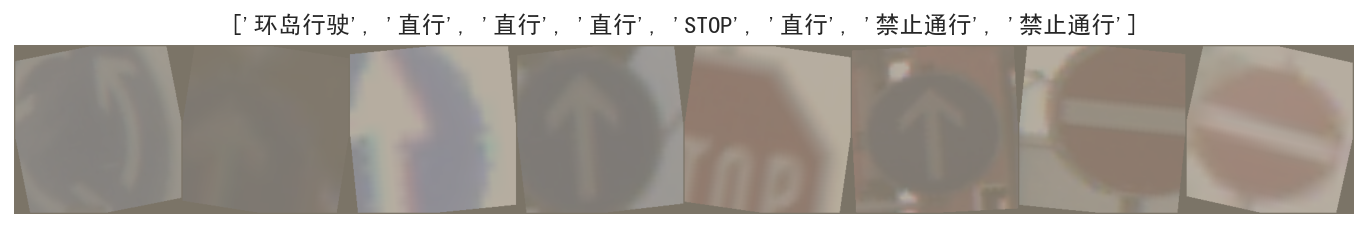

In [24]:
# 获取一批数据
inputs, labels = next(iter(data_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in labels])

In [25]:
# 迁移学习
def create_model(n_classes):
    model = models.resnet50(pretrained=True) # 下载预训练模型
    # 全连接层输入特征
    n_features = model.fc.in_features
    # 新的全连接层输入特征
    model.fc = nn.Linear(n_features, n_classes)
    return model.to(device)

In [26]:
# 创建模型对象
clf_model = create_model(len(class_names))

In [27]:
clf_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
# 函数：训练
def train(model, data_loader, criterion, optimizer, device, scheduler, n_examples):
    model.train()
    train_loss = []
    correct_pred = 0
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 梯度置零
        outputs = model(inputs) # 输出
        loss = criterion(outputs, labels) # 计算损失
        _, preds = torch.max(outputs, dim=1) # 获取到概率最大值的索引
        correct_pred += torch.sum(preds == labels) # 累计正确数
        train_loss.append(loss.item()) # 累计损失
        loss.backward() # 反向传播
        optimizer.step() # 更新参数
    scheduler.step() # 更新学习率
    # 返回平均损失，平均准确率
    return np.mean(train_loss), correct_pred.double()/n_examples

In [29]:
# 函数：验证
def evaluation(model, data_loader, criterion, device, n_examples):
    model.eval()
    eval_loss = []
    correct_pred = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) #输出
            loss = criterion(outputs, labels) # 损失
            _, preds = torch.max(outputs, dim=1) # 获取到概率最大值的索引
            correct_pred += torch.sum(preds == labels) # 累计正确数
            eval_loss.append(loss.item()) # 累计损失
    return np.mean(eval_loss), correct_pred.double() / n_examples

In [30]:
# 函数：开始训练
def train_model(model, data_loader, dataset_size, device, n_epochs=30):
    # 优化器
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # 动态学习率
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    # 损失函数
    criterion = nn.CrossEntropyLoss().to(device)
    # 假设最好的accuracy, history
    best_accuracy = 0.0
    history = defaultdict(list) # 构建一个默认value为list的字典
    
    for epoch in range(n_epochs):
        print(f'Epoch : {epoch + 1} / {n_epochs}')
        print('-' * 20)
        train_loss, train_accuracy = train(model, data_loader['train'], criterion, optimizer, device,
                                           scheduler, dataset_size['train'])
        print(f'Train Loss : {train_loss}, Train accuracy : {train_accuracy}')
        
        val_loss, val_accuracy = evaluation(model, data_loader['val'], criterion, device, dataset_size['val'])
        print(f'Val loss : {val_loss}, val accuracy : {val_accuracy}')
        
        # 保存所有结果
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        if val_accuracy > best_accuracy:
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_model_state_2.pkl')
            # 最好得分
            best_accuracy = val_accuracy
            
    print(f'Best Accuracy : {best_accuracy}')
        
    # 加载模型
    model.load_state_dict(torch.load("best_model_state_2.pkl"))
        
    return model, history

In [31]:
%%time

best_model, history = train_model(clf_model, data_loaders, dataset_size, device)

Epoch : 1 / 30
--------------------
Train Loss : 0.6232142846735306, Train accuracy : 0.7858326429163214
Val loss : 1.1294343096428905, val accuracy : 0.7149059334298118
Epoch : 2 / 30
--------------------
Train Loss : 0.38599158964113683, Train accuracy : 0.8695111847555923
Val loss : 3.4867780328482048, val accuracy : 0.42836468885672935
Epoch : 3 / 30
--------------------
Train Loss : 0.3636392393729199, Train accuracy : 0.8757249378624689
Val loss : 3.4210022818083052, val accuracy : 0.6309696092619391
Epoch : 4 / 30
--------------------
Train Loss : 0.2576160156260559, Train accuracy : 0.9130074565037282
Val loss : 3.531873513880218, val accuracy : 0.7062228654124457
Epoch : 5 / 30
--------------------
Train Loss : 0.20130670040426468, Train accuracy : 0.932062966031483
Val loss : 10.06696599310842, val accuracy : 0.4659913169319826
Epoch : 6 / 30
--------------------
Train Loss : 0.2569134933110758, Train accuracy : 0.9204639602319801
Val loss : 0.9860317674171094, val accuracy :

In [32]:
# 绘制 loss, acc
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='val loss')
    
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(history['train_acc'], label='train acc')
    ax2.plot(history['val_acc'], label='val acc')
    
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    
    fig.suptitle('Training History')

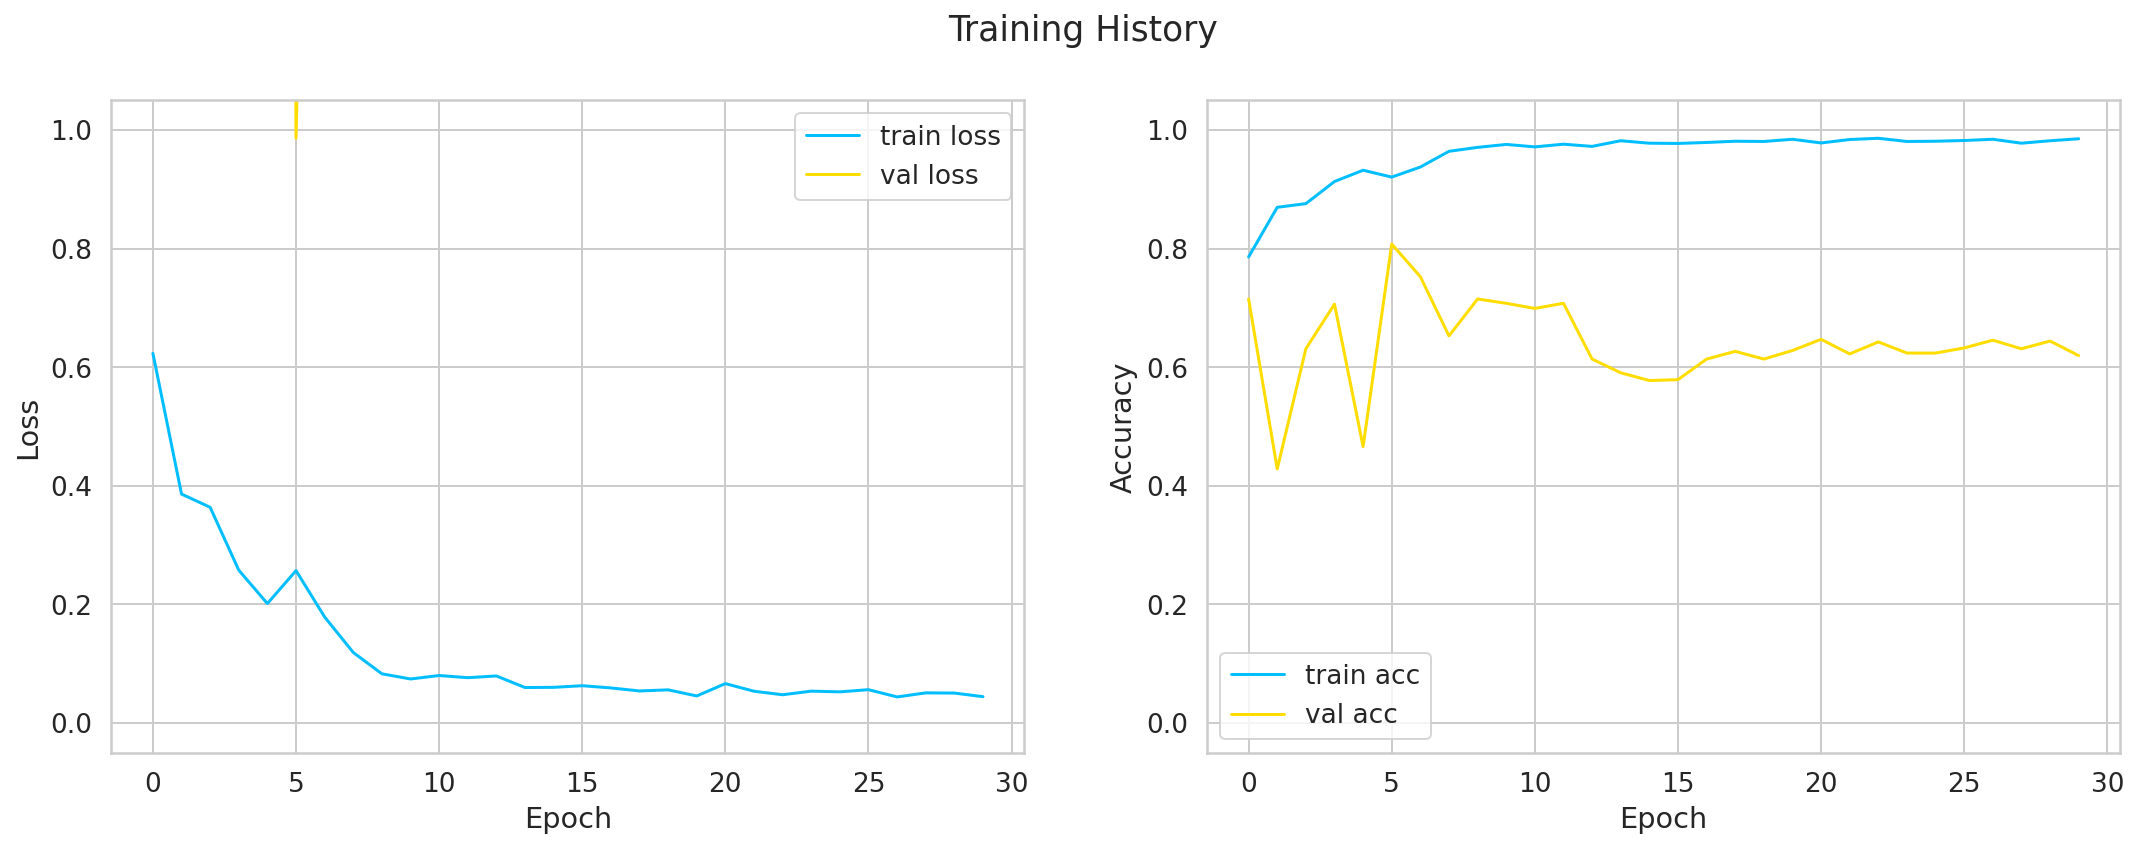

In [33]:
plot_training_history(history)

In [34]:
# 在test集上评估
def show_predictions(model, class_names, n_imgs=6):
    model.eval()
    images_handled = 0
    plt.figure()
    
    with torch.no_grad():
        my_font = FontProperties(fname='SimHei.ttf', size=12)
        
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            for j in range(inputs.shape[0]):
                images_handled += 1
                ax = plt.subplot(2, n_imgs // 2, images_handled)
                ax.set_title(f'predicted : {class_names[preds[j]]}', fontproperties=my_font)
                imshow(inputs.cpu().data[j])
                ax.axis('off')
                if images_handled == n_imgs:
                    return 

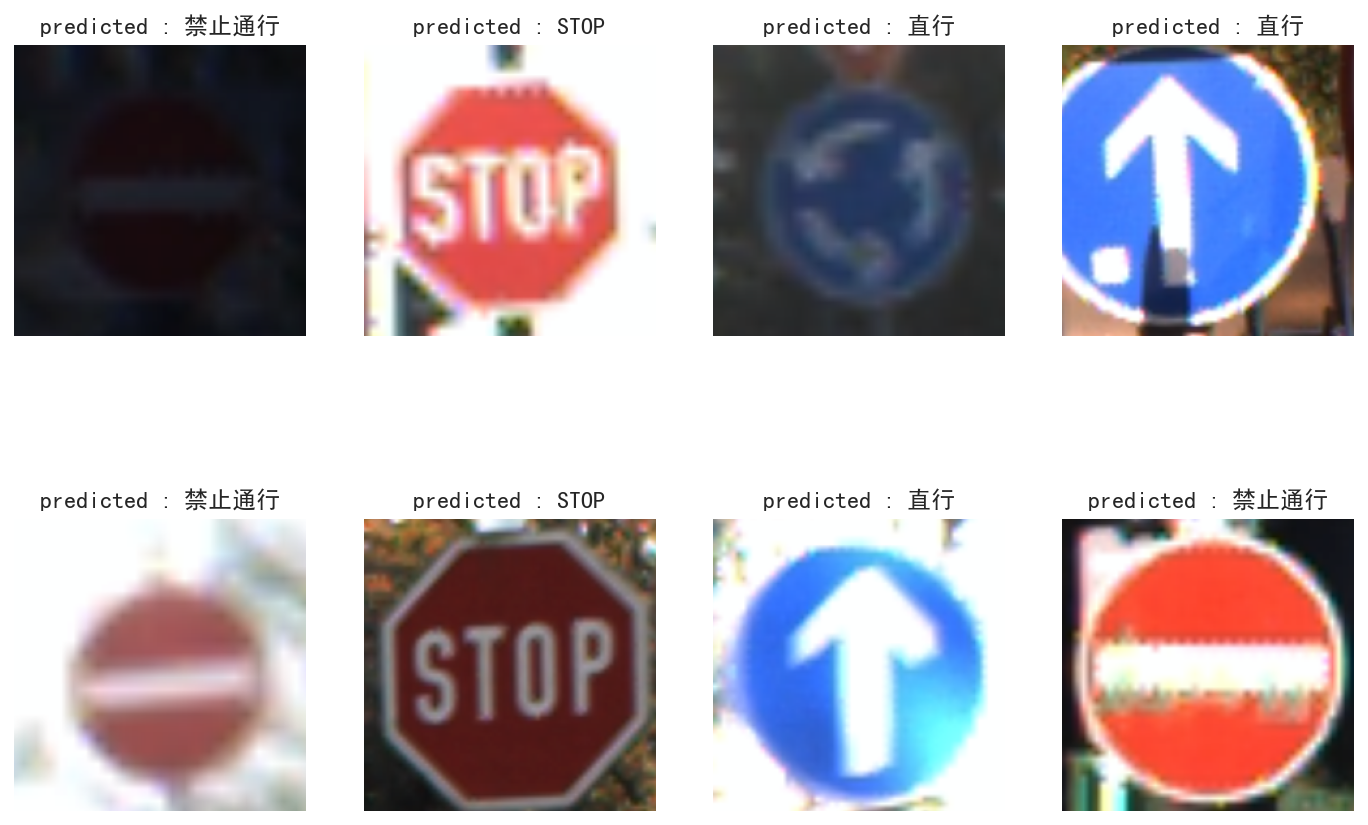

In [35]:
show_predictions(best_model, class_names, n_imgs=8)

In [36]:
# 根据预测结果，计算统计指标
def get_predictions(model, data_loaders):
    model.eval()
    predictions = [] # 预测值
    real_values = [] # 真值
    with torch.no_grad():
        for inputs, labels in data_loaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # 预测输出
            outputs = model(inputs)
            # 获取概率最大值索引
            _, preds = torch.max(outputs, dim=1)
            # 保存预测值和真值
            predictions.extend(preds)
            real_values.extend(labels)
        #print(predictions)
        #print(real_values)
        # 类型转换
        predictions = torch.as_tensor(predictions).cpu()
        real_values = torch.as_tensor(real_values).cpu()
        return predictions, real_values

In [37]:
y_pred, y_test = get_predictions(best_model, data_loaders['test'])

In [38]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        STOP       0.95      0.91      0.93        78
        环岛行驶       1.00      0.14      0.24        36
          直行       0.81      0.79      0.80       120
        禁止通行       0.75      1.00      0.86       111

    accuracy                           0.82       345
   macro avg       0.88      0.71      0.71       345
weighted avg       0.84      0.82      0.79       345



/home/tommy/PyTorch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 29615 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tommy/PyTorch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23707 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tommy/PyTorch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 34892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tommy/PyTorch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 39542 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tommy/PyTorch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tommy/PyTorch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarni

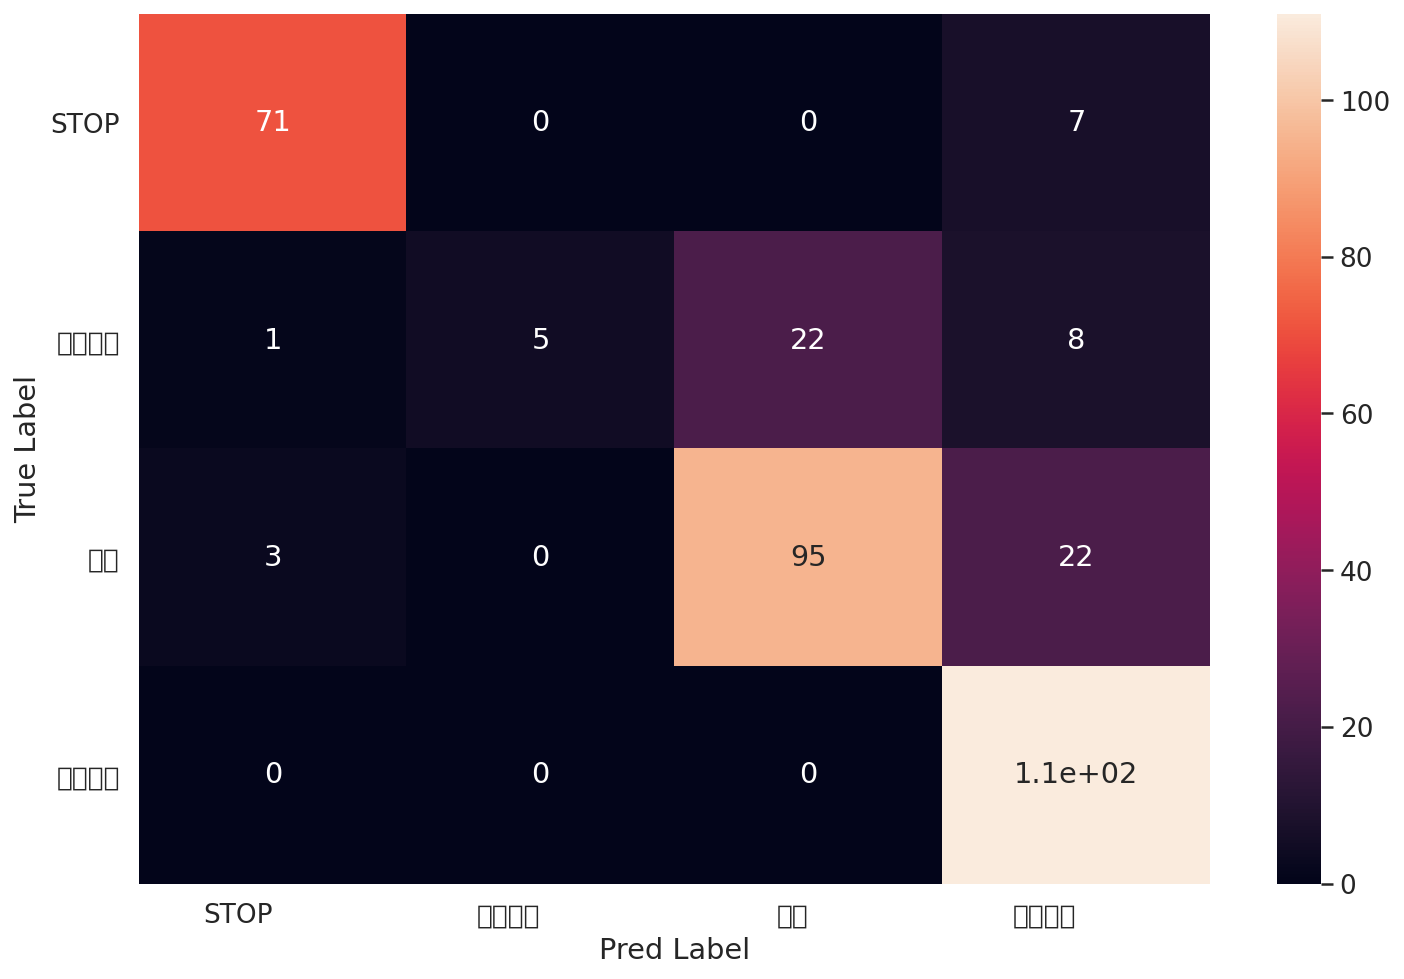

In [39]:
# 混淆矩阵
cm = confusion_matrix(y_test, y_pred) # 计算TP, FP, TN, FN
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
hmap = sns.heatmap(df_cm, annot=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True Label')
plt.xlabel('Pred Label')
plt.show()

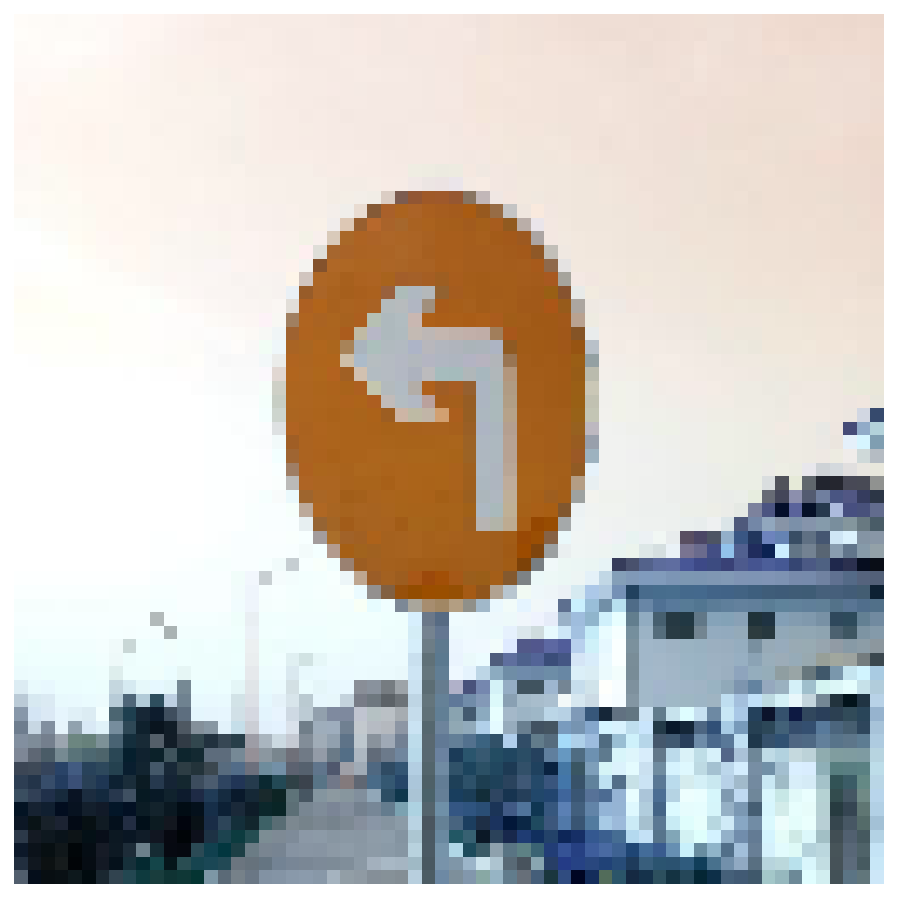

In [40]:
# 测试识别一张图片
test_path = 'test.jpg'

show_img(test_path)

In [41]:
# 函数：对图片进行识别，计算各个类别的概率
def predict_proba(model, img_path):
    # 读取图片
    image = Image.open(img_path)
    image = transform['test'](image).unsqueeze(0) # 图像变化，并扩充一维，充当batch_size
    print("test image shape :", image.shape)
    # 模型预测
    pred = model(image.to(device))
    print("output : ", pred)
    # 计算概率
    proba = F.softmax(pred, dim=1)
    print("proba : ", proba)
    """
    知识点：x.data() vs x.detach()
    相同：
    ① 都和 x 共享同一块数据
    ② 都和 x 的 计算历史无关
    ③ requires_grad = False
    不同：
    ① x.detach()更安全
    """
    #print("proba.data() ", proba.data()) 报错
    print("proba.detach()", proba.detach())
    
    return proba.detach().cpu().numpy().flatten() # flatten() : 返回一个一维数组

In [42]:
pred = predict_proba(best_model, test_path)

pred

test image shape : torch.Size([1, 3, 224, 224])
output :  tensor([[-3.6926, -0.8210,  2.7710, -3.7285]], device='cuda:0',
       grad_fn=<AddmmBackward>)
proba :  tensor([[0.0015, 0.0267, 0.9703, 0.0015]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
proba.detach() tensor([[0.0015, 0.0267, 0.9703, 0.0015]], device='cuda:0')


array([0.00151293, 0.02672534, 0.9703021 , 0.00145965], dtype=float32)

In [43]:
# 绘制结果

import warnings
warnings.filterwarnings('ignore')


def plot_prediction_confidence(prediction, class_names):
    sns.set(font='SimHei', font_scale=0.8)
    pred_df = pd.DataFrame({
        'class_names' : class_names,
        'values' : prediction
    })
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    
    plt.xlim([0, 1])
    plt.show()

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


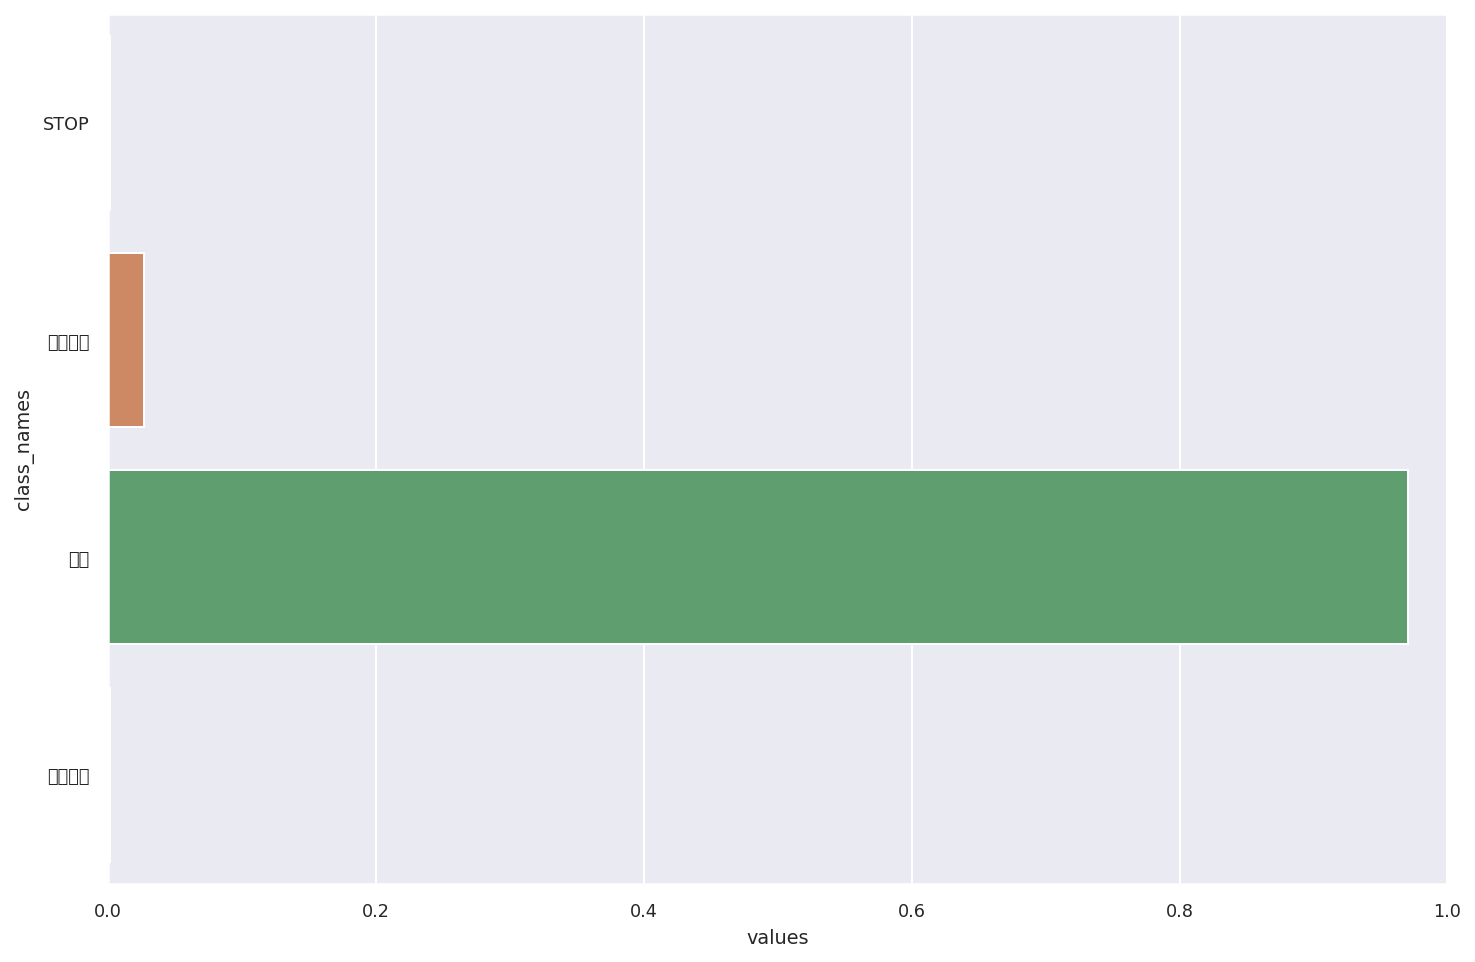

In [44]:
plot_prediction_confidence(pred, class_names)